# Caso de estudio: Reconstrucción del campo de flujo en una cavidad cuadrada

**Profesores**: Dr. Ing. Benjamin A. TOURN - Ing. Carlos G. MASSOBRIO

**Cohorte**: B32025

**Grupo**: N°2

**Alumno**: Maximiliano Torti

## EDP

**Ecuaciones de Navier-Stokes incompresibles**

$$(\mathbf{u}\cdot\nabla)\mathbf{u} = -\nabla p + 1/R_e \nabla^2 \mathbf{u}, \text{ en } \Omega $$
$$\nabla \mathbf{u} = 0, \text{ en } \Omega $$

## TP N°1: Puntos de colocacion

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
pressure_raw_data = scipy.io.loadmat('./Re-100/pressure.mat')
velocity_raw_data = scipy.io.loadmat('./Re-100/velocity.mat')

In [3]:
pressure_raw_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Apr  5 20:31:06 2023',
 '__version__': '1.0',
 '__globals__': [],
 'x': array([[0.   , 0.01 , 0.02 , ..., 0.975, 0.985, 0.995]]),
 'y': array([[0.   , 0.   , 0.   , ..., 0.995, 0.995, 0.995]]),
 'z': array([[0., 0., 0., ..., 0., 0., 0.]]),
 'p': array([[0.00000000e+00, 1.62864847e-05, 1.31113620e-05, ...,
         1.05833522e+00, 1.66906380e+00, 3.40199098e+00]])}

In [4]:
velocity_raw_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Apr  5 20:33:39 2023',
 '__version__': '1.0',
 '__globals__': [],
 'x': array([[0.   , 0.01 , 0.02 , ..., 0.975, 0.985, 0.995]]),
 'y': array([[0.   , 0.   , 0.   , ..., 0.995, 0.995, 0.995]]),
 'z': array([[0., 0., 0., ..., 0., 0., 0.]]),
 'u': array([[0.        , 0.        , 0.        , ..., 0.65946941, 0.49345089,
         0.17337734]]),
 'v': array([[ 0.        ,  0.        ,  0.        , ..., -0.03262434,
         -0.06381343, -0.15660411]]),
 'w': array([[0., 0., 0., ..., 0., 0., 0.]])}

### 1. Xpde y Xbc

In [5]:
# n_pde debe ser = n^2 para grilla regular
n_pde = 1024
n_bc= 100

x_lb = 0
x_ub = 1
y_lb = 0
y_ub = 1

#### Grilla regular

In [6]:
def get_xy_pde_mesh(x_bounds, y_bounds, n):
    x_step = (x_bounds[1]-x_bounds[0])/(np.sqrt(n) + 1)
    y_step = (y_bounds[1]-y_bounds[0])/(np.sqrt(n) + 1)
    x = np.arange(x_bounds[0] + x_step, x_bounds[1], x_step)
    y = np.arange(y_bounds[0]  + y_step, y_bounds[1], y_step)
    return np.array([[x_i, y_i] for x_i in x for y_i in y])

xy_pde_mesh = get_xy_pde_mesh([x_lb, x_ub], [y_lb, y_ub], n_pde)

In [7]:
def get_xy_bc_mesh(x_bounds, y_bounds, n):
    x_step = (x_bounds[1]-x_bounds[0])/(n / 4)
    y_step = (y_bounds[1]-y_bounds[0])/(n / 4)
    l1 = np.array([[x_i, y_bounds[0]] for x_i in np.arange(x_bounds[0], x_bounds[1], x_step)])
    l2 = np.array([[x_bounds[1], y_i] for y_i in np.arange(y_bounds[0], y_bounds[1], y_step)])
    l3 = np.array([[x_i, y_bounds[1]] for x_i in np.arange(x_bounds[1], x_bounds[0], -x_step)])
    l4 = np.array([[x_bounds[0], y_i] for y_i in np.arange(y_bounds[1], y_bounds[0], -y_step)])
    return np.concatenate([l1,l2,l3,l4], axis=0)

xy_bc_mesh = get_xy_bc_mesh([x_lb, x_ub], [y_lb, y_ub], n_bc)

#### Muestreo aleatorio

In [8]:
def get_xy_pde_random(x_bounds, y_bounds, n):
    x = np.random.uniform(np.nextafter(x_bounds[0], x_bounds[1]), x_bounds[1], n)
    y = np.random.uniform(np.nextafter(y_bounds[0], y_bounds[1]), y_bounds[1], n)
    return np.array([[x[i], y[i]] for i in range(n)])

xy_pde_random = get_xy_pde_random([x_lb, x_ub], [y_lb, y_ub], n_pde)

In [9]:
def get_xy_bc_random(x_bounds, y_bounds, n):
    xy = []
    for i in range(n):    
        side = random.choice(['top', 'right', 'bottom', 'left'])
        if side == 'top':
            xy.append([x_bounds[1], np.random.uniform(y_bounds[0], y_bounds[1], 1)[0]])
        elif side == 'right':
            xy.append([np.random.uniform(x_bounds[0], x_bounds[1], 1)[0], y_bounds[1]])
        elif side == 'bottom':
            xy.append([x_bounds[0], np.random.uniform(y_bounds[0], y_bounds[1], 1)[0]])
        else:  # side == 'left'
            xy.append([np.random.uniform(x_bounds[0], x_bounds[1], 1)[0], y_bounds[0]])
    return np.array(xy)

xy_bc_random = get_xy_bc_random([x_lb, x_ub], [y_lb, y_ub], n_bc)

### 2. Graficar puntos de colocación

#### Grilla regular

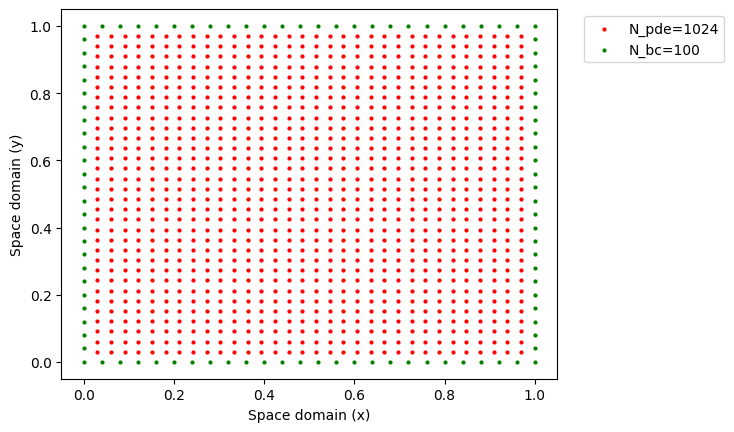

In [10]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xy_pde_mesh[:,0], xy_pde_mesh[:,1], s=4, c='r', label=f'N_pde={len(xy_pde_mesh)}')
ax.scatter(xy_bc_mesh[:,0], xy_bc_mesh[:,1], s=4, c='g', label=f'N_bc={len(xy_bc_mesh)}')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.legend()
plt.xlabel('Space domain (x)')
plt.ylabel('Space domain (y)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

#### Muestreo aleatorio

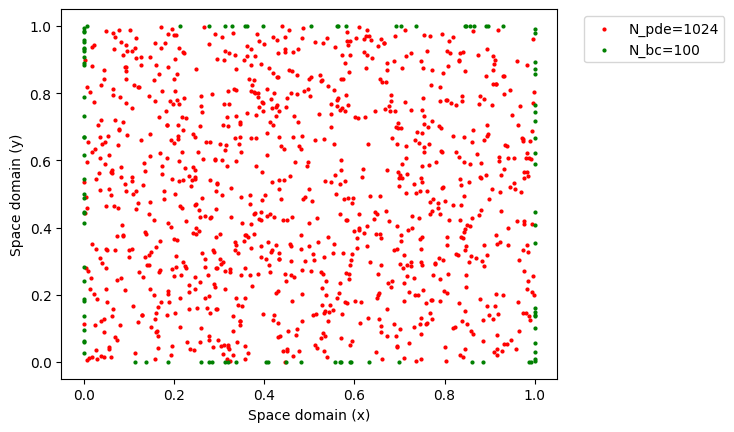

In [11]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xy_pde_random[:,0], xy_pde_random[:,1], s=4, c='r', label=f'N_pde={len(xy_pde_mesh)}')
ax.scatter(xy_bc_random[:,0], xy_bc_random[:,1], s=4, c='g', label=f'N_bc={len(xy_bc_mesh)}')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.legend()
plt.xlabel('Space domain (x)')
plt.ylabel('Space domain (y)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

### 3. Datos rotulados

In [12]:
n_data = 10

In [13]:
def get_ds_data(pressure_ds, velocity_ds, n):
    idxs = [random.randrange(0, len(pressure_raw_data['x'][0])) for _ in range(n)]
    xy = []
    labels = []
    for idx in idxs:
        assert pressure_ds['x'][0][idx] == velocity_ds['x'][0][idx]
        assert pressure_ds['y'][0][idx] == velocity_ds['y'][0][idx]
        xy.append([pressure_ds['x'][0][idx], pressure_ds['y'][0][idx]])
        labels.append([velocity_ds['u'][0][idx], velocity_ds['v'][0][idx], pressure_ds['p'][0][idx]])
    return np.array(xy), np.array(labels)

xy_data_random, labels_data_random = get_ds_data(pressure_raw_data, velocity_raw_data, n_data)

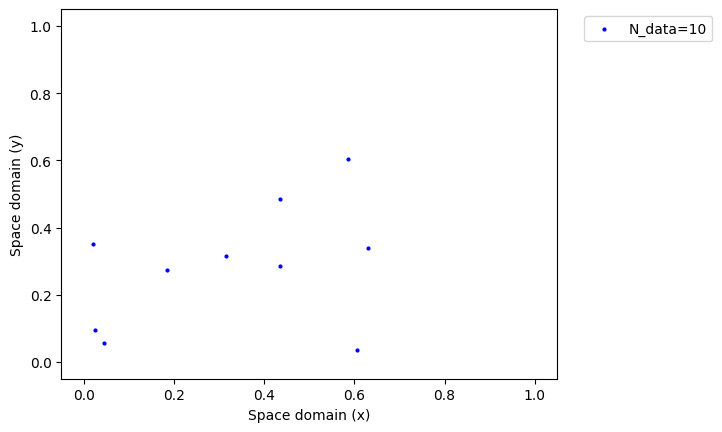

In [14]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xy_data_random[:,0], xy_data_random[:,1], s=4, c='b', label=f'N_data={len(xy_data_random)}')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.legend()
plt.xlabel('Space domain (x)')
plt.ylabel('Space domain (y)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

Este dataset de datos rotulados contiene no solamente los valores de input (x e y) del modelo sino también los valores de las etiquetas/salidas (p, u, v), por lo que constituye un caso de entrenamiento supervisado. En cambio, los datasets de puntos de colocación contienen solamente los valores de input (x e y) del modelo, por lo que se asemejaría más a un problema no supervisado, pero en realidad lo convertimos en "supervisado" a traves del uso de las EDP.

Como la estructura del dataset de datos rotulados y la de los datasets de puntos de colocación son diferentes, no podremos concatenarlos y seleccionar aleatoriamente batch que incluyan puntos de ambos al mismo tiempo. En su lugar, tendremos que entrenar el modelo de a pasos.

### 4. Para pensar

El sub-conjunto de los puntos de colocación xy_pde no debería contener puntos sobre la frontera del dominio, ya que la definición de la PDE se hace sobre el conjunto abierto del dominio (sin incluir el borde).

## TP N°2: Modelado PINN

### 1. Rutina PINN

Las ecuaciones vectoriales de Navier-Stokes incompresibles para 2D pueden ser desarrolladas como

$$ u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y}= -\frac{\partial p}{\partial x} + 1/R_e(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}), \text{ en } \Omega $$

$$ u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}= -\frac{\partial p}{\partial y} + 1/R_e(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}), \text{ en } \Omega $$

$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0, \text{ en } \Omega $$

In [15]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
 class PINN_Module(nn.Module):

    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Device = model_parameters["Device"]
        self.Reynolds = model_parameters["Reynolds"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = model_parameters["OutputDimensions"]
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)


    def forward(self, x):
        output = self.ActivationFunction(self.InputLayer(x))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        return output

    def pdeResidue(self, X, output):
        # Separate output in u,v and p
        u = output[:,0:1]
        v = output[:,1:2]
        p = output[:,2:3]
        
        # Compute the derivatives of the outputs u,v and p over the inputs (x,y) using AD mechanism:
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        diff_p = torch.autograd.grad(p, X, create_graph=True, grad_outputs=torch.ones_like(p))[0]
        u_x, u_y = diff_u[:, 0:1], diff_u[:, 1:2]
        v_x, v_y = diff_v[:, 0:1], diff_v[:, 1:2]
        p_x, p_y = diff_p[:, 0:1], diff_p[:, 1:2]

        # Compute the second derivative of the outputs u and v over the inputs (x,y) using AD mechanism:
        u_xx = torch.autograd.grad(u_x, X, create_graph=True, grad_outputs=torch.ones_like(u_x))[0][:, 0:1]
        u_yy = torch.autograd.grad(u_y, X, create_graph=True, grad_outputs=torch.ones_like(u_y))[0][:, 1:2]
        v_xx = torch.autograd.grad(v_x, X, create_graph=True, grad_outputs=torch.ones_like(v_x))[0][:, 0:1]
        v_yy = torch.autograd.grad(v_y, X, create_graph=True, grad_outputs=torch.ones_like(v_y))[0][:, 1:2]
        
        # Compute residues
        residue_continuity = u_x + v_y
        residue_momentum_x = u * u_x + v * u_y + p_x - (1/self.Reynolds) * (u_xx + u_yy)
        residue_momentum_y = u * v_x + v * v_y + p_y - (1/self.Reynolds) * (v_xx + v_yy)
        return residue_continuity, residue_momentum_x, residue_momentum_y

    def bcUVResidue(self, X, output):
        # Separate u and v from the output
        u = output[:,0:1]
        v = output[:,1:2]

        # Calculate true bc values 
        u_bc = (X[:,1:2] == 1) * 1.0 # u = 1 only at upper y bound, else 0
        v_bc = torch.zeros_like(v) # v = 0 on all border

        residue_u = u - u_bc
        residue_v = v - v_bc
        return residue_u, residue_v

    def bcPResidue(self, X, output):
        # Separate p from the output
        p = output[:,2:3]

        # Calculate true bc values 
        p_bc = torch.zeros_like(p) # p = 0 on the origin

        residue_p = p - p_bc
        return residue_p

In [18]:
def init_xavier(model):
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            # gain = nn.init.calculate_gain('tanh')
            gain = 1
            torch.nn.init.xavier_uniform_(m.weight, gain=gain)
            torch.nn.init.uniform_(m.bias, 0, 1)

    model.apply(init_weights)

### 2. Resolver PINN

In [19]:
model_parameters = {
    "Device": device,
    "Reynolds": 100,
    "InputDimensions": 2,
    "OutputDimensions": 3,
    "NumberOfNeurons": 50,
    "NumberOfHiddenLayers": 4,
    "ActivationFunction": nn.Tanh()
}

torch.manual_seed(10)
model = PINN_Module(model_parameters).to(device)
init_xavier(model)

In [20]:
# Initialization of data structures
xy_pde_random = get_xy_pde_random([x_lb, x_ub], [y_lb, y_ub], 10_000)
X_pde = torch.tensor(xy_pde_random, requires_grad = True).float().to(device)

xy_bc_random = get_xy_bc_random([x_lb, x_ub], [y_lb, y_ub], 1_000)
X_bc = torch.tensor(xy_bc_random).float().to(device)

X_bc_0 = torch.tensor([[0, 0]]).float().to(device)

epochs = 15000
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_train = {'Overall' : [], 
              'PDE': [], 'PDE_Continuity': [], 'PDE_MomentumX': [], 'PDE_MomentumY': [], \
              'BC': [], 'BC_U': [], 'BC_V': [], 'BC_P': []}

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()

    # PDE
    output_pde = model(X_pde)
    residue_continuity, residue_momentum_x, residue_momentum_y  = model.pdeResidue(X_pde, output_pde)
    loss_pde_continuity = loss_fn(residue_continuity, torch.zeros_like(residue_continuity))
    loss_pde_momentum_x = loss_fn(residue_momentum_x, torch.zeros_like(residue_momentum_x))
    loss_pde_momentum_y = loss_fn(residue_momentum_y, torch.zeros_like(residue_momentum_y))
    loss_pde = loss_pde_continuity + loss_pde_momentum_x + loss_pde_momentum_y
    
    # BC
    output_bc = model(X_bc)
    residue_u, residue_v = model.bcUVResidue(X_bc, output_bc)
    loss_bc_u = loss_fn(residue_u, torch.zeros_like(residue_u))
    loss_bc_v = loss_fn(residue_v, torch.zeros_like(residue_v))
    output_bc_0 = model(X_bc_0)
    residue_p = model.bcPResidue(X_bc_0, output_bc_0)
    loss_bc_p = loss_fn(residue_p, torch.zeros_like(residue_p))
    loss_bc = loss_bc_u + loss_bc_v + loss_bc_p

    # Loss, backpropagation and gradient descent
    loss_overall = loss_pde + loss_bc
    loss_overall.backward()
    optimizer.step()

    # Log
    loss_train['Overall'].append(loss_overall.item())
    loss_train['PDE'].append(loss_pde.item())
    loss_train['PDE_Continuity'].append(loss_pde_continuity.item())
    loss_train['PDE_MomentumX'].append(loss_pde_momentum_x.item())
    loss_train['PDE_MomentumY'].append(loss_pde_momentum_y.item())
    loss_train['BC'].append(loss_bc.item())
    loss_train['BC_U'].append(loss_bc_u.item())
    loss_train['BC_V'].append(loss_bc_v.item())
    loss_train['BC_P'].append(loss_bc_p.item())
    if (epoch+1) % 100 == 0:
        tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item()}, PDE: {loss_pde.item()}, BC: {loss_bc.item()}")

  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 100/15000 - Loss Overall: 0.16514183580875397, PDE: 0.00079218705650419, BC: 0.16434964537620544
Epoch 200/15000 - Loss Overall: 0.13314630091190338, PDE: 0.0005760990898124874, BC: 0.13257020711898804
Epoch 300/15000 - Loss Overall: 0.10819050669670105, PDE: 0.0005464670248329639, BC: 0.10764403641223907
Epoch 400/15000 - Loss Overall: 0.09746619313955307, PDE: 0.0005063918652012944, BC: 0.09695979952812195
Epoch 500/15000 - Loss Overall: 0.09503503143787384, PDE: 0.00038180453702807426, BC: 0.09465322643518448
Epoch 600/15000 - Loss Overall: 0.0938989520072937, PDE: 0.00025165564147755504, BC: 0.0936472937464714
Epoch 700/15000 - Loss Overall: 0.09274826943874359, PDE: 0.00016361268353648484, BC: 0.09258465468883514
Epoch 800/15000 - Loss Overall: 0.0914846733212471, PDE: 0.00011692655243678018, BC: 0.09136774390935898
Epoch 900/15000 - Loss Overall: 0.09007377922534943, PDE: 0.00010839183232747018, BC: 0.08996538817882538
Epoch 1000/15000 - Loss Overall: 0.08847676217556, PDE:

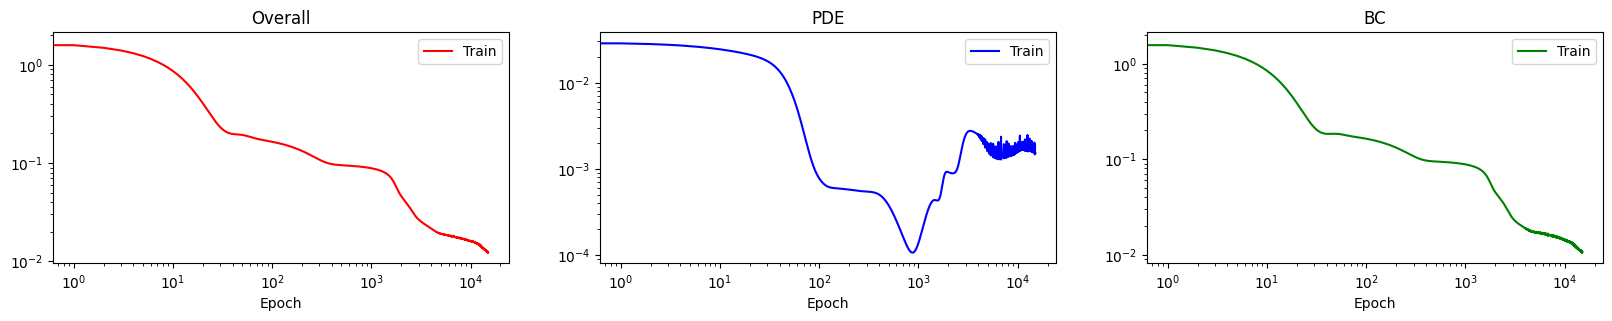

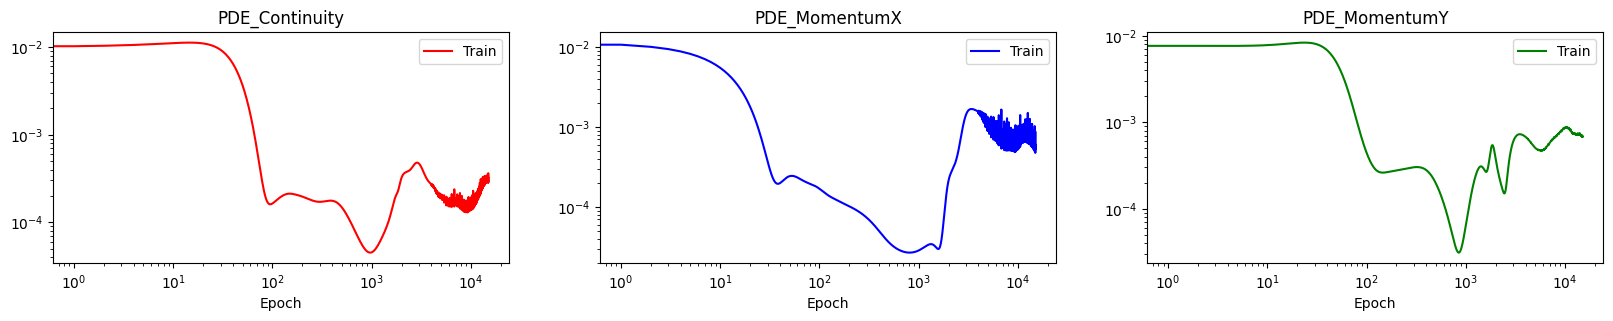

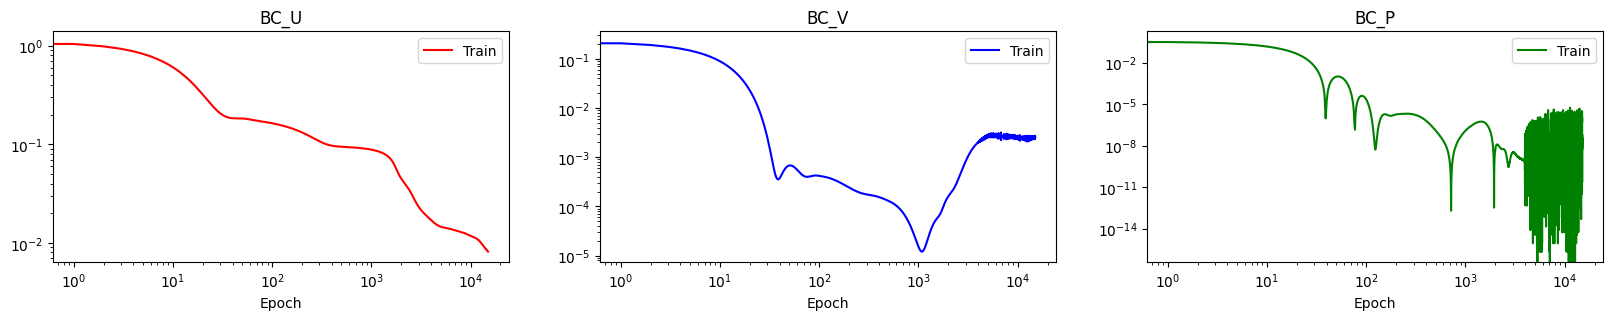

In [21]:
# Evolution of the loss function
colors = ['red', 'blue', 'green']
# Overall
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
for i, loss_type in enumerate(['Overall', 'PDE', 'BC']):
    epoch_train = np.arange(0, len(loss_train[loss_type]))
    ax[i].loglog(epoch_train, loss_train[loss_type], color=colors[i], label='Train')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(loss_type)
    ax[i].legend()
plt.show()
    
# PDE
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
for i, loss_type in enumerate(['PDE_Continuity', 'PDE_MomentumX', 'PDE_MomentumY']):
    epoch_train = np.arange(0, len(loss_train[loss_type]))
    ax[i].loglog(epoch_train, loss_train[loss_type], color=colors[i], label='Train')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(loss_type)
    ax[i].legend()
plt.show()

# BC
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
for i, loss_type in enumerate(['BC_U', 'BC_V', 'BC_P']):
    epoch_train = np.arange(0, len(loss_train[loss_type]))ñ
    ax[i].loglog(epoch_train, loss_train[loss_type], color=colors[i], label='Train')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(loss_type)
    ax[i].legend()
plt.show()

In [22]:
torch.save(model.state_dict(), "./model.pt")

### 3. Calculo de error

In [23]:
from sklearn.metrics import mean_squared_error

In [24]:
xy_data_all = np.concatenate([pressure_raw_data['x'][0][:,np.newaxis], pressure_raw_data['y'][0][:,np.newaxis]], axis=1)
labels_data_all = np.concatenate([velocity_raw_data['u'][0][:,np.newaxis],velocity_raw_data['v'][0][:,np.newaxis],
                                 pressure_raw_data['p'][0][:,np.newaxis]], axis=1)

In [25]:
model.train(False)
with torch.no_grad():
    X_data = torch.tensor(xy_data_all).float().to(device)
    output_data = model(X_data).cpu().numpy()

In [26]:
mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
print(f"Normal 2  del error (ECM) en u: {mse_u}, v: {mse_v}, p: {mse_p}")

Normal 2  del error (ECM) en u: 0.007737604962467811, v: 0.0156355189943061, p: 0.008602958137073766


### 4. Graficas error absoluto

In [27]:
from matplotlib import cm

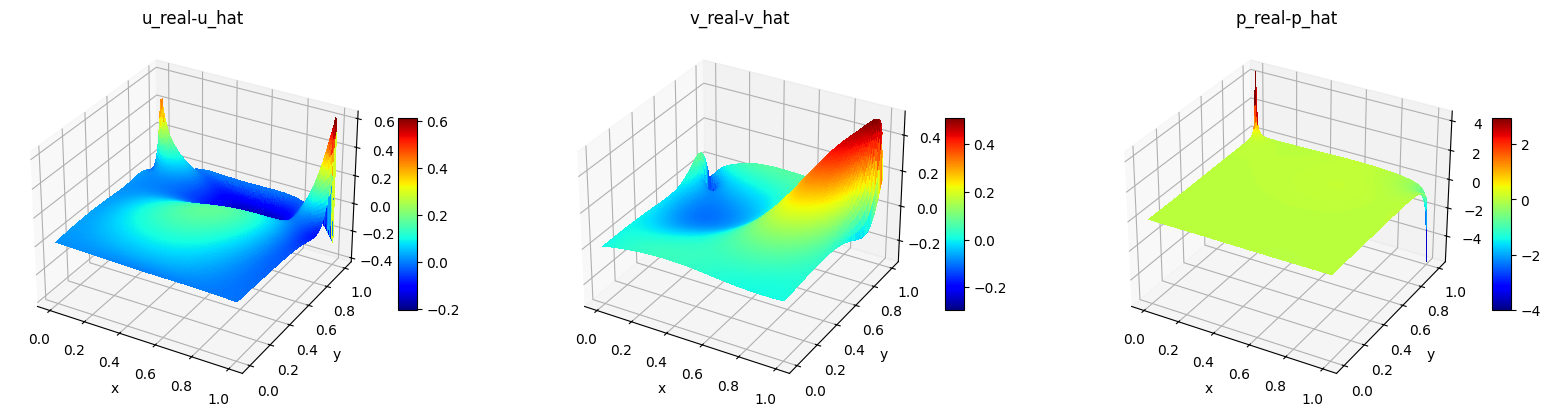

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), subplot_kw=dict(projection='3d'))
# u graph
ax = axs[0]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], output_data[:,0]-labels_data_all[:,0], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('u_real-u_hat')

# v graph
ax = axs[1]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], output_data[:,1]-labels_data_all[:,1], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('v_real-v_hat')

# p graph
ax = axs[2]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], output_data[:,2]-labels_data_all[:,2], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('p_real-p_hat')
plt.show()

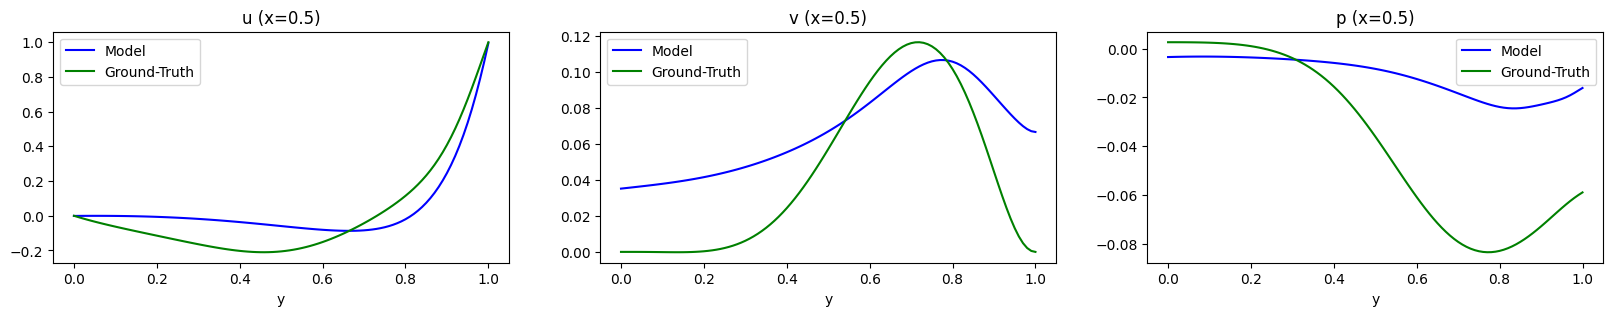

In [29]:
# Grafica sobre x=0.5
mask_x05 = np.where(xy_data_all[:, 0] == 0.5)
xy_data_x05 = xy_data_all[mask_x05]
labels_data_x05 = labels_data_all[mask_x05]

model.train(False)
with torch.no_grad():
    X_data = torch.tensor(xy_data_x05).float().to(device)
    output_data = model(X_data).cpu().numpy()

fig, ax = plt.subplots(1, 3, figsize=(20, 3))
for i, title in enumerate(['u', 'v', 'p']):
    epoch_train = np.arange(0, len(loss_train[loss_type]))
    ax[i].plot(xy_data_x05[:,1], output_data[:,i], color='blue', label='Model')
    ax[i].plot(xy_data_x05[:,1], labels_data_x05[:,i], color='green', label='Ground-Truth')
    ax[i].set_xlabel('y')
    ax[i].set_title(f"{title} (x=0.5)")
    ax[i].legend()
plt.show()

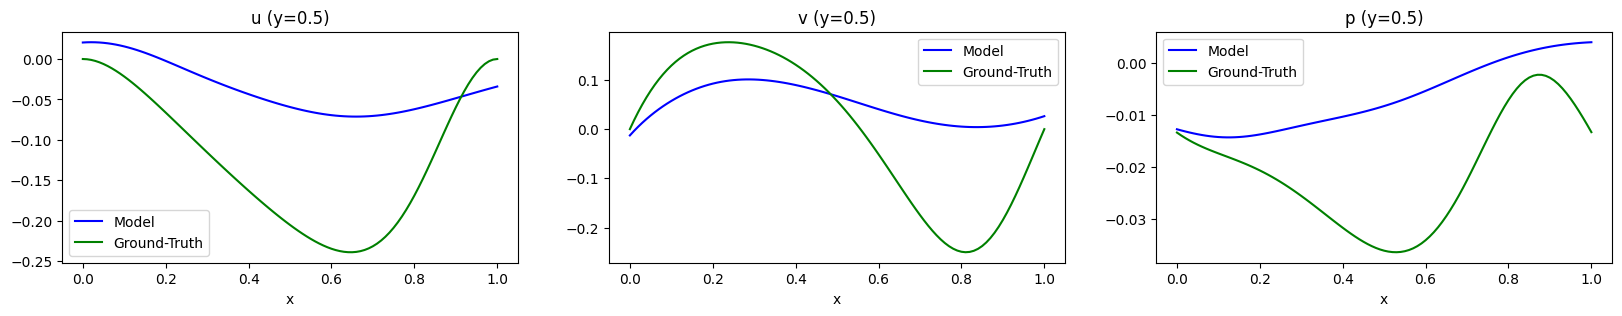

In [30]:
# Grafica sobre x=0.5
mask_y05 = np.where(xy_data_all[:, 1] == 0.5)
xy_data_y05 = xy_data_all[mask_y05]
labels_data_y05 = labels_data_all[mask_y05]

model.train(False)
with torch.no_grad():
    X_data = torch.tensor(xy_data_y05).float().to(device)
    output_data = model(X_data).cpu().numpy()

fig, ax = plt.subplots(1, 3, figsize=(20, 3))
for i, title in enumerate(['u', 'v', 'p']):
    epoch_train = np.arange(0, len(loss_train[loss_type]))
    ax[i].plot(xy_data_y05[:,0], output_data[:,i], color='blue', label='Model')
    ax[i].plot(xy_data_y05[:,0], labels_data_y05[:,i], color='green', label='Ground-Truth')
    ax[i].set_xlabel('x')
    ax[i].set_title(f"{title} (y=0.5)")
    ax[i].legend()
plt.show()

### 5. Analisis

De acuerdo a lo observado, a pesar de que el ECM es bajo, el modelo no parece ser lo suficientemente bueno para predecir los campos de presión y velocidad.

En la evolución de la pérdida, se observa que todas las componente decrecen a medida que pasan las epochs. Si bien el residuo de la PDE aumenta sobre las últimas epochs, si entrenásemos el modelo con mayor cantidad de epochs disminuiría neuvamente. Al finalizar el entrenamiento, se obserba que la pérdida sobre la PDE se encuentra ordenes de magnitud por debajo del residuo de la condición de borde.

De las gráficas del error absoluto se obserba que el mayor error se encuentra en las zona de mayor variación de los campos. Al graficar los perfiles u,v y p para x=0.5 e y=0.5 tanto para el modelo como para el ground-truth, observamos que el modelo no capta las variaciones de los valores y tiende a suavizar los campos.

Considero que los hiperparámetros seleccionados no son los mejores pero tampoco incorrectos, y que una optimización de los mismos solo produciría mejoras márginales. En este caso, para lograr mejoras sustanciales es necesario considerar cambios en la arquitectura de la solución.

Para mejorar el desempeño podríamos por ejemplo reemplazar la arquitectura por una implementación "hard" de las condiciones de borde. Por otro lado, también podríamos utilizar una mejor estrategia al conjugar todos los residuos que la actual estrategia naive de sumar todos los componentes por igual.

## TP N°3: Estrategias de muestreo de puntos de colocación

In [31]:
# Shared model parameters
model_parameters = {
    "Device": device,
    "Reynolds": 100,
    "InputDimensions": 2,
    "OutputDimensions": 3,
    "NumberOfNeurons": 50,
    "NumberOfHiddenLayers": 4,
    "ActivationFunction": nn.Tanh()
}
n_datasets = [(1000, 100), (10000, 1000), (100000, 10000)]
epochs = 10000
lr = 1e-4

# Shared ground truth
xy_data_all = np.concatenate([pressure_raw_data['x'][0][:,np.newaxis], pressure_raw_data['y'][0][:,np.newaxis]], axis=1)
labels_data_all = np.concatenate([velocity_raw_data['u'][0][:,np.newaxis],velocity_raw_data['v'][0][:,np.newaxis],
                                 pressure_raw_data['p'][0][:,np.newaxis]], axis=1)

In [32]:
def train_step(model, X_pde, X_bc):
    # PDE
    output_pde = model(X_pde)
    residue_continuity, residue_momentum_x, residue_momentum_y  = model.pdeResidue(X_pde, output_pde)
    loss_pde_continuity = loss_fn(residue_continuity, torch.zeros_like(residue_continuity))
    loss_pde_momentum_x = loss_fn(residue_momentum_x, torch.zeros_like(residue_momentum_x))
    loss_pde_momentum_y = loss_fn(residue_momentum_y, torch.zeros_like(residue_momentum_y))
    loss_pde = loss_pde_continuity + loss_pde_momentum_x + loss_pde_momentum_y
    # BC
    output_bc = model(X_bc)
    residue_u, residue_v = model.bcUVResidue(X_bc, output_bc)
    loss_bc_u = loss_fn(residue_u, torch.zeros_like(residue_u))
    loss_bc_v = loss_fn(residue_v, torch.zeros_like(residue_v))
    output_bc_0 = model(X_bc_0)
    residue_p = model.bcPResidue(X_bc_0, output_bc_0)
    loss_bc_p = loss_fn(residue_p, torch.zeros_like(residue_p))
    loss_bc = 10 * (loss_bc_u + loss_bc_v) + loss_bc_p
    return loss_pde, loss_bc

### Muestreo aleatorio uniforme

In [33]:
rand_mse_error = []

print("Random Sample Dataset Train")
for n_pde, n_bc in n_datasets:
    # Init
    torch.manual_seed(10)
    model = PINN_Module(model_parameters).to(device)
    init_xavier(model)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    xy_pde_random = get_xy_pde_random([x_lb, x_ub], [y_lb, y_ub], n_pde)
    X_pde = torch.tensor(xy_pde_random, requires_grad = True).float().to(device)
    xy_bc_random = get_xy_bc_random([x_lb, x_ub], [y_lb, y_ub], n_bc)
    X_bc = torch.tensor(xy_bc_random).float().to(device)
    X_bc_0 = torch.tensor([[0, 0]]).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Npde = {n_pde} | Nbc = {n_bc}")
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss_pde, loss_bc = train_step(model, X_pde, X_bc)
        loss_overall = loss_pde + loss_bc
        loss_overall.backward()
        optimizer.step()
        if (epoch+1) % 100 == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item()}, PDE: {loss_pde.item()}, BC: {loss_bc.item()}")
        torch.cuda.empty_cache()

    # Calculate error
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_all).float().to(device)
        output_data = model(X_data).cpu().numpy()
    mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
    mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
    mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
    rand_mse_error.append({'mse_u': mse_u, 'mse_v': mse_v, 'mse_p': mse_p})
    print(f"Error on ground-truth mse_u: {mse_u} | mse_v: {mse_v} | mse_p: {mse_p}")
    torch.cuda.empty_cache()

Random Sample Dataset Train
------------------------------------------------------------
Npde = 1000 | Nbc = 100


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 100/10000 - Loss Overall: 1.7626186609268188, PDE: 0.016223501414060593, BC: 1.7463951110839844
Epoch 200/10000 - Loss Overall: 1.3552206754684448, PDE: 0.008092377334833145, BC: 1.3471282720565796
Epoch 300/10000 - Loss Overall: 1.0947941541671753, PDE: 0.0038469943683594465, BC: 1.090947151184082
Epoch 400/10000 - Loss Overall: 1.0181256532669067, PDE: 0.0018362525152042508, BC: 1.0162893533706665
Epoch 500/10000 - Loss Overall: 0.9981114864349365, PDE: 0.0015341360121965408, BC: 0.9965773224830627
Epoch 600/10000 - Loss Overall: 0.9814422726631165, PDE: 0.0012804680736735463, BC: 0.9801617860794067
Epoch 700/10000 - Loss Overall: 0.9614298343658447, PDE: 0.0010286291362717748, BC: 0.960401177406311
Epoch 800/10000 - Loss Overall: 0.9359902739524841, PDE: 0.0007942280499264598, BC: 0.935196042060852
Epoch 900/10000 - Loss Overall: 0.9026511907577515, PDE: 0.0006619196501560509, BC: 0.9019892811775208
Epoch 1000/10000 - Loss Overall: 0.8581430315971375, PDE: 0.000866700545884668

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 100/10000 - Loss Overall: 1.6944400072097778, PDE: 0.01873166486620903, BC: 1.675708293914795
Epoch 200/10000 - Loss Overall: 1.279015302658081, PDE: 0.009449630975723267, BC: 1.2695657014846802
Epoch 300/10000 - Loss Overall: 1.0134696960449219, PDE: 0.0041238972917199135, BC: 1.0093457698822021
Epoch 400/10000 - Loss Overall: 0.9480671286582947, PDE: 0.0018307773862034082, BC: 0.9462363719940186
Epoch 500/10000 - Loss Overall: 0.934124231338501, PDE: 0.0014430044684559107, BC: 0.9326812028884888
Epoch 600/10000 - Loss Overall: 0.9213449358940125, PDE: 0.0011983169242739677, BC: 0.920146644115448
Epoch 700/10000 - Loss Overall: 0.9059971570968628, PDE: 0.0009409306803718209, BC: 0.9050562381744385
Epoch 800/10000 - Loss Overall: 0.8869014978408813, PDE: 0.0006714933551847935, BC: 0.8862299919128418
Epoch 900/10000 - Loss Overall: 0.8624793887138367, PDE: 0.000431894208304584, BC: 0.8620474934577942
Epoch 1000/10000 - Loss Overall: 0.8306180834770203, PDE: 0.0003499941958580166, 

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 100/10000 - Loss Overall: 1.6025577783584595, PDE: 0.018493834882974625, BC: 1.5840638875961304
Epoch 200/10000 - Loss Overall: 1.2144129276275635, PDE: 0.00908172968775034, BC: 1.2053312063217163
Epoch 300/10000 - Loss Overall: 0.9662336111068726, PDE: 0.004068187437951565, BC: 0.9621654152870178
Epoch 400/10000 - Loss Overall: 0.9022465348243713, PDE: 0.0018780346726998687, BC: 0.9003685116767883
Epoch 500/10000 - Loss Overall: 0.889224112033844, PDE: 0.0015325419371947646, BC: 0.8876915574073792
Epoch 600/10000 - Loss Overall: 0.8780351281166077, PDE: 0.0013323542661964893, BC: 0.8767027854919434
Epoch 700/10000 - Loss Overall: 0.8646333813667297, PDE: 0.0011054100468754768, BC: 0.8635279536247253
Epoch 800/10000 - Loss Overall: 0.8480387926101685, PDE: 0.0008499349933117628, BC: 0.8471888303756714
Epoch 900/10000 - Loss Overall: 0.8269895315170288, PDE: 0.0005902580451220274, BC: 0.8263992667198181
Epoch 1000/10000 - Loss Overall: 0.7997838258743286, PDE: 0.000412121851695701

### Hipercubo Latino (LHS)

In [34]:
from pyDOE import lhs

In [35]:
def get_xy_pde_lhs(x_bounds, y_bounds, n):
    x = x_bounds[0] + (x_bounds[1] - x_bounds[0])  * lhs(1, n)[:,0]
    y = y_bounds[0] + (y_bounds[1] - y_bounds[0])  * lhs(1, n)[:,0]
    return np.array([[x[i], y[i]] for i in range(n)])

In [36]:
def get_xy_bc_lhs(x_bounds, y_bounds, n):
    xy = []
    for i in range(n):    
        side = random.choice(['top', 'right', 'bottom', 'left'])
        if side == 'top':
            xy.append([x_bounds[1], y_bounds[0] + (y_bounds[1] - y_bounds[0])  * lhs(1, 1)[0,0]])
        elif side == 'right':
            xy.append([x_bounds[0] + (x_bounds[1] - x_bounds[0])  * lhs(1, 1)[0,0], y_bounds[1]])
        elif side == 'bottom':
            xy.append([x_bounds[0], y_bounds[0] + (y_bounds[1] - y_bounds[0])  * lhs(1, 1)[0,0]])
        else:  # side == 'left'
            xy.append([x_bounds[0] + (x_bounds[1] - x_bounds[0])  * lhs(1, 1)[0,0], y_bounds[0]])
    return np.array(xy)

In [37]:
lhs_mse_error = []

print("Latin hypercube sampling Dataset Train")
for n_pde, n_bc in n_datasets:
    # Init
    torch.manual_seed(10)
    model = PINN_Module(model_parameters).to(device)
    init_xavier(model)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    xy_pde_lhs = get_xy_pde_lhs([x_lb, x_ub], [y_lb, y_ub], n_pde)
    X_pde = torch.tensor(xy_pde_lhs, requires_grad = True).float().to(device)
    xy_bc_lhs = get_xy_bc_lhs([x_lb, x_ub], [y_lb, y_ub], n_bc)
    X_bc = torch.tensor(xy_bc_lhs).float().to(device)
    X_bc_0 = torch.tensor([[0, 0]]).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Npde = {n_pde} | Nbc = {n_bc}")
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss_pde, loss_bc = train_step(model, X_pde, X_bc)
        loss_overall = loss_pde + loss_bc
        loss_overall.backward()
        optimizer.step()
        if (epoch+1) % 100 == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item()}, PDE: {loss_pde.item()}, BC: {loss_bc.item()}")
        torch.cuda.empty_cache()

    # Calculate error
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_all).float().to(device)
        output_data = model(X_data).cpu().numpy()
    mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
    mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
    mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
    lhs_mse_error.append({'mse_u': mse_u, 'mse_v': mse_v, 'mse_p': mse_p})
    print(f"Error on ground-truth mse_u: {mse_u} | mse_v: {mse_v} | mse_p: {mse_p}")
    torch.cuda.empty_cache()

Latin hypercube sampling Dataset Train
------------------------------------------------------------
Npde = 1000 | Nbc = 100


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 100/10000 - Loss Overall: 1.626404047012329, PDE: 0.01664644666016102, BC: 1.6097575426101685
Epoch 200/10000 - Loss Overall: 1.213199257850647, PDE: 0.00835547037422657, BC: 1.2048437595367432
Epoch 300/10000 - Loss Overall: 0.9506199359893799, PDE: 0.005725846625864506, BC: 0.9448940753936768
Epoch 400/10000 - Loss Overall: 0.8868255019187927, PDE: 0.0046857791021466255, BC: 0.8821397423744202
Epoch 500/10000 - Loss Overall: 0.8732619881629944, PDE: 0.004612718243151903, BC: 0.8686492443084717
Epoch 600/10000 - Loss Overall: 0.8603952527046204, PDE: 0.004426322411745787, BC: 0.8559689521789551
Epoch 700/10000 - Loss Overall: 0.8450260162353516, PDE: 0.004190852865576744, BC: 0.8408351540565491
Epoch 800/10000 - Loss Overall: 0.826239287853241, PDE: 0.003930066246539354, BC: 0.8223091959953308
Epoch 900/10000 - Loss Overall: 0.8027545213699341, PDE: 0.0036846818402409554, BC: 0.7990698218345642
Epoch 1000/10000 - Loss Overall: 0.7728336453437805, PDE: 0.0035692802630364895, BC: 

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 100/10000 - Loss Overall: 1.6741461753845215, PDE: 0.018104324117302895, BC: 1.6560418605804443
Epoch 200/10000 - Loss Overall: 1.2301112413406372, PDE: 0.009082472883164883, BC: 1.2210288047790527
Epoch 300/10000 - Loss Overall: 0.9643359184265137, PDE: 0.0040875752456486225, BC: 0.9602483510971069
Epoch 400/10000 - Loss Overall: 0.9056803584098816, PDE: 0.0018882169388234615, BC: 0.903792142868042
Epoch 500/10000 - Loss Overall: 0.8930923938751221, PDE: 0.0015172917628660798, BC: 0.8915750980377197
Epoch 600/10000 - Loss Overall: 0.881191074848175, PDE: 0.0012767902808263898, BC: 0.8799142837524414
Epoch 700/10000 - Loss Overall: 0.8669459819793701, PDE: 0.0010246543679386377, BC: 0.8659213185310364
Epoch 800/10000 - Loss Overall: 0.8493695259094238, PDE: 0.0007544242544099689, BC: 0.8486151099205017
Epoch 900/10000 - Loss Overall: 0.8271437883377075, PDE: 0.0004974360344931483, BC: 0.8266463279724121
Epoch 1000/10000 - Loss Overall: 0.7985055446624756, PDE: 0.00035727836075238

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 100/10000 - Loss Overall: 1.6240062713623047, PDE: 0.018063191324472427, BC: 1.6059430837631226
Epoch 200/10000 - Loss Overall: 1.2279863357543945, PDE: 0.00880482792854309, BC: 1.2191815376281738
Epoch 300/10000 - Loss Overall: 0.9742962121963501, PDE: 0.00406825914978981, BC: 0.9702279567718506
Epoch 400/10000 - Loss Overall: 0.9085447192192078, PDE: 0.0019352787639945745, BC: 0.9066094160079956
Epoch 500/10000 - Loss Overall: 0.8947640061378479, PDE: 0.0015783581184223294, BC: 0.8931856751441956
Epoch 600/10000 - Loss Overall: 0.8827226161956787, PDE: 0.0013567060232162476, BC: 0.8813658952713013
Epoch 700/10000 - Loss Overall: 0.8682524561882019, PDE: 0.001113381702452898, BC: 0.8671391010284424
Epoch 800/10000 - Loss Overall: 0.8502762317657471, PDE: 0.0008443264523521066, BC: 0.8494319319725037
Epoch 900/10000 - Loss Overall: 0.8274016976356506, PDE: 0.0005799595382995903, BC: 0.8268217444419861
Epoch 1000/10000 - Loss Overall: 0.7977629899978638, PDE: 0.0004252077196724713

### Muestreo adaptativo basado en residuos (RAD)

In [41]:
def get_xy_pde_rad(x_bounds, y_bounds, n, model, k=1, c=1, oversampling = 5):
    xy_pde_base = get_xy_pde_random(x_bounds, y_bounds, n * oversampling)
    X_pde_base = torch.tensor(xy_pde_base, requires_grad = True).float().to(device)
    output_pde = model(X_pde_base)
    residue_continuity, residue_momentum_x, residue_momentum_y  = model.pdeResidue(X_pde_base, output_pde)
    epsilon = torch.pow(torch.abs(residue_momentum_x), k) + torch.pow(torch.abs(residue_momentum_y), k)
    err_eq = epsilon/epsilon.mean() + c
    err_eq_normalized = (err_eq/sum(err_eq))[:, 0]
    idx = np.random.choice(a=len(X_pde_base), size=n, replace=False, p=err_eq_normalized.data.cpu().detach().numpy())
    return X_pde_base[idx.flatten(), :].cpu().detach().numpy()

In [42]:
def get_xy_bc_rad(x_bounds, y_bounds, n, model, k=1, c=1, oversampling = 5):
    xy_bc_base = get_xy_bc_random(x_bounds, y_bounds, n * oversampling)
    X_bc_base = torch.tensor(xy_bc_base, requires_grad = True).float().to(device)
    output_bc = model(X_bc_base)
    residue_u, residue_v = model.bcUVResidue(X_bc_base, output_bc)
    epsilon = torch.pow(torch.abs(residue_u), k) + torch.pow(torch.abs(residue_v), k)
    err_eq = epsilon/epsilon.mean() + c
    err_eq_normalized = (err_eq/sum(err_eq))[:, 0]
    idx = np.random.choice(a=len(X_bc_base), size=n, replace=False, p=err_eq_normalized.data.cpu().detach().numpy())
    return X_bc_base[idx.flatten(), :].cpu().detach().numpy()

In [43]:
rad_mse_error = []

print("Residual-based Adaptative Distribution sampling Dataset Train")
for n_pde, n_bc in n_datasets:
    # Init
    torch.manual_seed(10)
    model = PINN_Module(model_parameters).to(device)
    init_xavier(model)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    xy_pde_random = get_xy_pde_random([x_lb, x_ub], [y_lb, y_ub], n_pde)
    X_pde = torch.tensor(xy_pde_random, requires_grad = True).float().to(device)
    xy_bc_random = get_xy_bc_random([x_lb, x_ub], [y_lb, y_ub], n_bc)
    X_bc = torch.tensor(xy_bc_random).float().to(device)
    X_bc_0 = torch.tensor([[0, 0]]).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Npde = {n_pde} | Nbc = {n_bc}")
    for epoch in tqdm(range(epochs)):
        # RAD strategy
        if epoch % (epochs/10) == 0 and epoch!=0:
            xy_pde_rad = get_xy_pde_rad([x_lb, x_ub], [y_lb, y_ub], n_pde, model)
            X_pde = torch.tensor(xy_pde_rad, requires_grad = True).float().to(device)
            xy_bc_rad = get_xy_bc_rad([x_lb, x_ub], [y_lb, y_ub], n_bc, model)
            X_bc = torch.tensor(xy_bc_rad).float().to(device)
            torch.cuda.empty_cache()
            tqdm.write(f"New dataset sampling based on RAD strategy")
        
        optimizer.zero_grad()
        loss_pde, loss_bc = train_step(model, X_pde, X_bc)
        loss_overall = loss_pde + loss_bc
        loss_overall.backward()
        optimizer.step()
        if (epoch+1) % 100 == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item()}, PDE: {loss_pde.item()}, BC: {loss_bc.item()}")
        torch.cuda.empty_cache()

    # Calculate error
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_all).float().to(device)
        output_data = model(X_data).cpu().numpy()
    mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
    mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
    mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
    rad_mse_error.append({'mse_u': mse_u, 'mse_v': mse_v, 'mse_p': mse_p})
    print(f"Error on ground-truth mse_u: {mse_u} | mse_v: {mse_v} | mse_p: {mse_p}")
    torch.cuda.empty_cache()

Residual-based Adaptative Distribution sampling Dataset Train
------------------------------------------------------------
Npde = 1000 | Nbc = 100


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 100/10000 - Loss Overall: 1.2759078741073608, PDE: 0.017574753612279892, BC: 1.2583330869674683
Epoch 200/10000 - Loss Overall: 1.014428734779358, PDE: 0.007850016467273235, BC: 1.0065786838531494
Epoch 300/10000 - Loss Overall: 0.8261978626251221, PDE: 0.004041168838739395, BC: 0.8221566677093506
Epoch 400/10000 - Loss Overall: 0.7579264044761658, PDE: 0.0025194536428898573, BC: 0.7554069757461548
Epoch 500/10000 - Loss Overall: 0.7431256175041199, PDE: 0.0023093633353710175, BC: 0.7408162355422974
Epoch 600/10000 - Loss Overall: 0.7336685061454773, PDE: 0.0022416997235268354, BC: 0.7314268350601196
Epoch 700/10000 - Loss Overall: 0.7224351763725281, PDE: 0.002116532064974308, BC: 0.720318615436554
Epoch 800/10000 - Loss Overall: 0.7084002494812012, PDE: 0.001948743942193687, BC: 0.7064515352249146
Epoch 900/10000 - Loss Overall: 0.6904394030570984, PDE: 0.0017444288823753595, BC: 0.688694953918457
Epoch 1000/10000 - Loss Overall: 0.6669060587882996, PDE: 0.0015418140683323145, 

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 100/10000 - Loss Overall: 1.7330684661865234, PDE: 0.016903895884752274, BC: 1.7161645889282227
Epoch 200/10000 - Loss Overall: 1.2990329265594482, PDE: 0.008360163308680058, BC: 1.290672779083252
Epoch 300/10000 - Loss Overall: 1.028396487236023, PDE: 0.004623487591743469, BC: 1.023772954940796
Epoch 400/10000 - Loss Overall: 0.9646528959274292, PDE: 0.0028977319598197937, BC: 0.9617551565170288
Epoch 500/10000 - Loss Overall: 0.9505250453948975, PDE: 0.002600335516035557, BC: 0.9479247331619263
Epoch 600/10000 - Loss Overall: 0.9369545578956604, PDE: 0.0023488912265747786, BC: 0.9346056580543518
Epoch 700/10000 - Loss Overall: 0.9206562638282776, PDE: 0.0020805858075618744, BC: 0.9185757040977478
Epoch 800/10000 - Loss Overall: 0.900520920753479, PDE: 0.0017968895845115185, BC: 0.8987240195274353
Epoch 900/10000 - Loss Overall: 0.8750365376472473, PDE: 0.0015473448438569903, BC: 0.8734892010688782
Epoch 1000/10000 - Loss Overall: 0.842200756072998, PDE: 0.0014764193911105394, B

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 100/10000 - Loss Overall: 1.6079552173614502, PDE: 0.018609365448355675, BC: 1.5893458127975464
Epoch 200/10000 - Loss Overall: 1.2262535095214844, PDE: 0.009105479344725609, BC: 1.2171480655670166
Epoch 300/10000 - Loss Overall: 0.9774266481399536, PDE: 0.004070970695465803, BC: 0.9733556509017944
Epoch 400/10000 - Loss Overall: 0.9118866324424744, PDE: 0.0018790224567055702, BC: 0.9100075960159302
Epoch 500/10000 - Loss Overall: 0.8987320065498352, PDE: 0.001520922756753862, BC: 0.8972110748291016
Epoch 600/10000 - Loss Overall: 0.8874488472938538, PDE: 0.0013118917122483253, BC: 0.8861369490623474
Epoch 700/10000 - Loss Overall: 0.8739143013954163, PDE: 0.0010778788710013032, BC: 0.8728364109992981
Epoch 800/10000 - Loss Overall: 0.8571446537971497, PDE: 0.0008167934138327837, BC: 0.8563278317451477
Epoch 900/10000 - Loss Overall: 0.8358595371246338, PDE: 0.0005535318632610142, BC: 0.8353059887886047
Epoch 1000/10000 - Loss Overall: 0.8083370923995972, PDE: 0.00037594902096316

### Grafica error vs tamaño del dataset

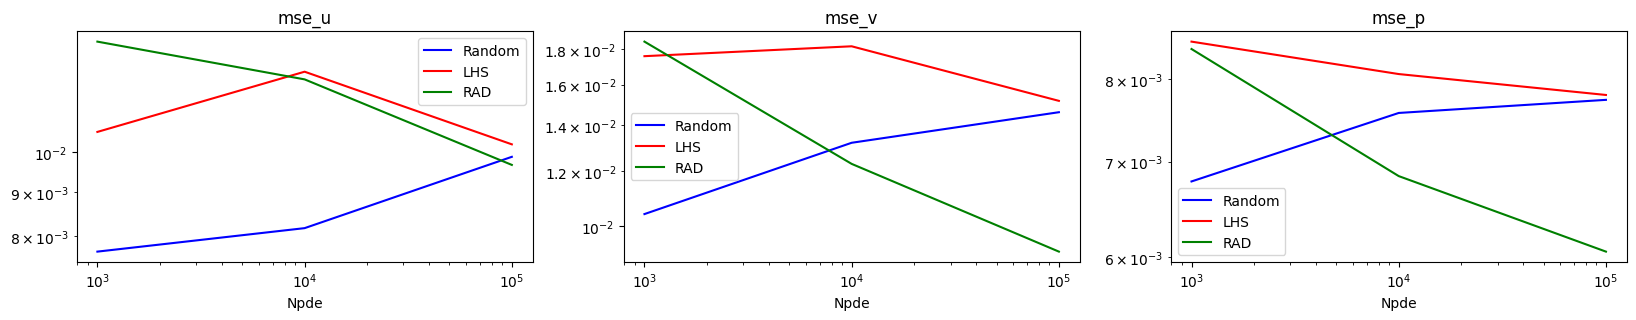

In [52]:
n_datasets
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
for i, title in enumerate(['mse_u', 'mse_v', 'mse_p']):
    ax[i].loglog([n[0] for n in n_datasets], [error[title] for error in rand_mse_error], color='blue', label='Random')
    ax[i].loglog([n[0] for n in n_datasets], [error[title] for error in lhs_mse_error], color='red', label='LHS')
    ax[i].loglog([n[0] for n in n_datasets], [error[title] for error in rad_mse_error], color='green', label='RAD')
    ax[i].set_xlabel('Npde')
    ax[i].set_title(f"{title}")
    ax[i].legend()
plt.show()